# 💳 Credit Card - 사기 탐지(Anomaly Detection)
🎯 신용카드 거래 데이터에서 정상 거래인지, 사기 거래인지를 분류하는 이진 분류 문제

## ✅ 1. 데이터 전처리

### 📌 1-1. 데이터 로딩

In [22]:
import pandas as pd

# 데이터 로드
df = pd.read_csv("/Users/lee_hyejoo/Desktop/hyejoo/학교/3학년 1학기/머신러닝/중간_대체/신용카드_사기_탐지, Credit Card Fraud - Anomaly Detection/creditcard.csv")

# 기본 정보 확인
print("데이터 크기:", df.shape)
df.head()

데이터 크기: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 📌 1-2. 클래스 분포 확인 (불균형 문제 파악)

In [23]:
df["Class"].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

💡 설명
- 데이터의 거의 전부가 정상 거래이며,사기 거래는 전체의 0.17%밖에 안 됨
- 따라서 일반적인 모델을 그냥 학습시키면 → 무조건 “0(정상)”만 예측해도 높은 정확도가 나오게 됨 → 실제로 사기를 탐지하는 데 전혀 쓸모 없는 모델

---

### 📌 1-3. 불균형 데이터 처리 - 언더샘플링

In [24]:
# 정상(0)과 사기(1) 거래 분리
fraud = df_normalized[df_normalized['Class'] == 1]
normal = df_normalized[df_normalized['Class'] == 0].sample(n=len(fraud), random_state=42)

# 언더샘플링된 데이터셋 결합
df_under = pd.concat([fraud, normal]).sample(frac=1, random_state=42).reset_index(drop=True)

# 클래스 분포 확인
df_under['Class'].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

### 📌 1-3. 불균형 데이터 처리 - SMOTE

In [25]:
from imblearn.over_sampling import SMOTE

# Feature, Label 분리
X = df_normalized.drop(columns=['Class'])
y = df_normalized['Class']

# SMOTE 적용
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# 확인
pd.Series(y_smote).value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

📌 차이 요약

항목 | 언더샘플링 | SMOTE (오버샘플링)

전략 | 정상 샘플 줄임 | 사기 샘플 합성

장점 | 빠르고 단순, 과적합 적음 | 정보 손실 없음, 전체 데이터 활용

단점 | 정보 손실 큼 | 과적합 위험, 느림

데이터 수 | 줄어듦 | 늘어남

적합 모델 | 빠른 실험, 트리 계열 | 거리 기반, 딥러닝 계열

주의점 | 너무 적게 남으면 성능 저하 | 고차원에서는 SMOTE 품질 ↓

🔍 판단 기준

🔸 📉 데이터가 너무 많고 트리 계열 모델 위주 → 언더샘플링(빠르고 overfitting 적음)

🔸 📈 거리 기반 모델(Logistic, Autoencoder 등), 딥러닝 포힘 → SMOTE(데이터가 풍부해지고, 소수 클래스 학습에 유리)

✅ 선택 ➡️ SMOTE
- 전체 데이터를 그대로 살릴 수 있음
- Autoencoder, Logistic처럼 데이터 분포에 민감한 모델에 더 잘 맞음
- recision-Recall Curve, AUC 평가처럼 소수 클래스 성능이 중요할 때 유리



---

### 📌 1-4 거래 금액 정규화

In [26]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 📌 SMOTE 적용 결과를 DataFrame으로
df_smote_scaled = pd.DataFrame(X_smote, columns=X.columns)
df_smote_scaled['Class'] = y_smote

# Amount 정규화
scaler = StandardScaler()
df_smote_scaled['Amount'] = scaler.fit_transform(df_smote_scaled[['Amount']])

# 확인
df_smote_scaled[['Amount']].describe()

,Amount
count,5.686300e+05
mean,-4.398485e-18
std,1.000001e+00
min,-4.234909e-01
25%,-4.126068e-01
50%,-3.254165e-01
75%,1.182922e-02
max,1.114265e+02


🔍 해석

count  |  5.686300e+05   → 총 568,630건의 거래 데이터 (SMOTE로 클래스 수 맞춘 후 전체 수 늘어남)

mean  |  -4.398485e-18   → 평균값은 거의 0 (표준화가 잘 됨을 의미)

std   |   1.000001e+00   → 표준편차는 1 (정규화된 범위 기준)

min  |   -4.234909e-01   → 가장 낮은 값은 약 -0.42

25%   |  -4.126068e-01   → 하위 25% 지점도 약 -0.41 (대부분 값이 음수에 몰려 있음)

50%   |  -3.254165e-01   → 중앙값은 약 -0.33

75%   |   1.182922e-02   → 상위 25% 지점부터 양수

max   |   1.114265e+02   → 최대값은 약 111.4



➡️ 거래 금액의 분포가 한쪽에 치우쳐져 있었기 때문에, 정규화 이후에도 음수 쪽에 값이 많고, 일부 큰 값(이상치)이 존재함

➡️ 하지만 평균과 표준편차 기준으로는 정규화가 잘 적용됨 (mean ≈ 0, std ≈ 1)

___

## 🤖 2. 모델 학습 및 비교

### 📌 2-1. 기본 모델 - 로지스틱 회귀 (Logistic Regression)

💡 설명
- 이진 분류(Binary Classification) 문제를 해결하기 위해 널리 사용되는 선형 모델
- 선형 회귀와 달리 출력값을 0~1 사이의 확률로 바꾸기 위해 시그모이드 함수(𝜎) 사용
- 확률이 특정 임계값(보통 0.5)을 넘으면 클래스 1, 아니면 클래스 0으로 분류

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 모델 정의 및 학습
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 예측
y_pred_lr = lr_model.predict(X_test)

# 결과 확인
print("🔵 [Logistic Regression]")
print(classification_report(y_test, y_pred_lr, digits=4))

🔵 [Logistic Regression]
              precision    recall  f1-score   support

           0     0.9226    0.9743    0.9477     56863
           1     0.9727    0.9182    0.9447     56863

    accuracy                         0.9462    113726
   macro avg     0.9477    0.9462    0.9462    113726
weighted avg     0.9477    0.9462    0.9462    113726



🔍 해석
- 정상 거래(0)의 recall이 0.97로 높은 이유는 대부분의 거래가 정상이라 잘 분류됨
- 사기 거래(1)의 precision이 0.97로 매우 높아, 예측된 사기 중 거의 다가 진짜 사기
- 반대로 recall이 0.9182로 다소 낮은 건 여전히 일부 사기 거래를 놓쳤다는 것을 의미
- 전체 accuracy 94.62%는 굉장히 높지만, SMOTE로 균형 잡았기 때문에 신뢰 가능한 수치

➡️ SMOTE로 클래스 비율을 균형 맞춘 후 모델 학습을 수행하였고, Logistic Regression에서도 precision과 recall이 모두 0.92 이상을 기록하며 균형 잡힌 분류 성능을 보임

➡️ 특히 사기 탐지(클래스 1)의 precision이 높아, 실제 탐지된 사기의 정확성이 높다는 장점이 있음


---

### 📌 2-2. 기본 모델 - Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# 모델 정의 및 학습
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# 예측
y_pred_dt = dt_model.predict(X_test)

# 결과 확인
print("🌳 [Decision Tree]")
print(classification_report(y_test, y_pred_dt, digits=4))

🌳 [Decision Tree]
              precision    recall  f1-score   support

           0     0.9447    0.9627    0.9536     56863
           1     0.9620    0.9437    0.9527     56863

    accuracy                         0.9532    113726
   macro avg     0.9534    0.9532    0.9532    113726
weighted avg     0.9534    0.9532    0.9532    113726



🔍 해석
- 정상 거래(0)의 recall이 0.9627로 매우 높아, 대부분의 정상 거래를 잘 식별
- 사기 거래(1)의 precision이 0.9620, recall도 0.9437로 높은 수준 → 예측된 사기 중 대부분이 실제 사기였고, 놓친 것도 상대적으로 적음
- 전체 accuracy 95.32%, macro avg / weighted avg F1-score도 모두 0.953 이상으로 우수한 성능을 보임

➡️ Decision Tree는 간단한 모델임에도 불구하고 클래스 간 균형 잡힌 성능을 보여주며, 특히 사기 거래 탐지에서도 precision-recall 모두 안정적인 수준을 유지

➡️ 복잡한 모델 없이도 높은 해석력과 안정성을 제공하므로, 빠르고 명확한 판단이 중요한 금융 환경에서 유용

---

### 📌 2.5 고급 모델 - Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 모델 정의 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred_rf = rf_model.predict(X_test)

# 결과 출력
print("🌲 [Random Forest]")
print(classification_report(y_test, y_pred_rf, digits=4))

🌲 [Random Forest]
              precision    recall  f1-score   support

           0     1.0000    0.9997    0.9999     56863
           1     0.9997    1.0000    0.9999     56863

    accuracy                         0.9999    113726
   macro avg     0.9999    0.9999    0.9999    113726
weighted avg     0.9999    0.9999    0.9999    113726



🔍 해석
- 정상 거래(0)의 precision: 1.0000 / recall: 0.9997 → 거의 모든 정상 거래를 정확하게 예측함
- 사기 거래(1)의 precision: 0.9997 / recall: 1.0000 → 탐지된 사기 거래 중 거의 모두 실제 사기이며, 놓친 건 없음
- accuracy 0.9999는 모델이 전체적으로 매우 뛰어난 분류 성능을 보였음을 의미
- 특히 SMOTE로 클래스 균형을 맞춘 후 Random Forest를 적용했을 때, 거의 완벽에 가까운 성능을 나타냄

➡️ 랜덤포레스트는 복잡한 비선형 패턴도 잘 잡아내는 앙상블 모델로, 이상치 탐지 성능이 매우 우수함

➡️ 실제 적용 가능성이 높은 안정적인 모델 중 하나로 판단됨

### 📌 2.6 고급 모델 - XGBoost

In [31]:
from xgboost import XGBClassifier

# 모델 정의 및 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 예측
y_pred_xgb = xgb_model.predict(X_test)

# 결과 출력
print("📦 [XGBoost]")
print(classification_report(y_test, y_pred_xgb, digits=4))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:12:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📦 [XGBoost]
              precision    recall  f1-score   support

           0     1.0000    0.9993    0.9996     56863
           1     0.9993    1.0000    0.9996     56863

    accuracy                         0.9996    113726
   macro avg     0.9996    0.9996    0.9996    113726
weighted avg     0.9996    0.9996    0.9996    113726



🔍 해석
- 정상 거래(0): precision = 1.0000, recall = 0.9993 → 정상 거래는 거의 100% 정확하게 분류됨
- 사기 거래(1): precision = 0.9993, recall = 1.0000 → 사기 거래를 놓치지 않고 모두 탐지
- 전체 accuracy 0.9996, macro/weighted 평균도 모두 0.9996 → 모델이 거의 완벽하게 분류한 수준

➡️ XGBoost는 Gradient Boosting 기반으로 학습하며, 개별 오차를 반복적으로 줄여나가 뛰어난 성능을 보임

➡️ 랜덤 포레스트와 마찬가지로 비선형 패턴 탐지에 강하고, 특히 데이터 불균형 문제를 해결한 이후에는 사기 탐지(class 1) 성능이 매우 뛰어남

### 📌 2.7 고급 모델 - Isolation Forest

💡섦명
- 이상치(anomaly)를 격리하는 방식으로 탐지하는 비지도 학습 알고리즘
- 트리를 무작위로 구성하고, 데이터가 얼마나 빨리 고립되는지를 측정하여 이상치를 판단
- 주로 이상 탐지(Anomaly Detection)에 특화됨

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# 모델 정의 및 학습
iso_model = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
iso_model.fit(X_train)

# 예측 (Isolation Forest는 이상치를 -1로 반환함)
y_pred_iso = iso_model.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# 결과 출력
print("🧊 [Isolation Forest]")
print(classification_report(y_test, y_pred_iso, digits=4))


🧊 [Isolation Forest]
              precision    recall  f1-score   support

           0     0.5008    1.0000    0.6674     56863
           1     1.0000    0.0033    0.0067     56863

    accuracy                         0.5017    113726
   macro avg     0.7504    0.5017    0.3370    113726
weighted avg     0.7504    0.5017    0.3370    113726



🔍 해석 
- 정상 거래(0):Precision = 0.5008, Recall = 1.0000 → 정상 거래는 모두 탐지했지만, 예측된 정상 중 절반은 사기로 잘못 판단
- 사기 거래(1): Precision = 1.0000, Recall = 0.0033 → 탐지된 사기 중 실제로는 모두 사기였지만, 대부분의 사기를 놓쳤음
- Accuracy = 0.5017 → 전체적으로 예측을 거의 절반 확률로 맞춘 셈
- F1-score (class 1)는 0.0067로 매우 낮음, 실전에서는 사용 어려움

➡️ Isolation Forest는 비지도 학습 기반 이상 탐지 모델로 사전 라벨링이 필요 없어 편리하지만, 이처럼 불균형 데이터에선 거의 모든 데이터를 정상으로 판단하는 경향이 있어 실제 사기를 잘 잡아내지 못함

➡️ 정상 클래스 비율이 높은 데이터에서는 한계가 있음 → 정교한 이상탐지에는 비지도보다는 지도 학습 기반 접근이 효과적

---

### 📌 2.8 딥러닝 모델 - Autoencoder 기반 이상탐지

💡 설명
- Autoencoder는 입력 데이터를 압축(encoding)한 뒤 다시 복원(decoding)하도록 학습하는 비지도 학습 신경망
- 정상 데이터를 기반으로 학습한 후, 입력과 출력의 재구성 오차(Reconstruction Error)가 큰 데이터를 이상치로 판단

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np

#  Autoencoder 구조 정의
input_dim = X_train.shape[1]
encoding_dim = 14  # 압축 차원

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#  Autoencoder 학습 (정상 거래만 사용)
X_train_auto = X_train[y_train == 0]  # 정상 거래만
X_test_auto = X_test  # 테스트는 전체

history = autoencoder.fit(
    X_train_auto, X_train_auto,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test_auto, X_test_auto),
    verbose=1
)

Epoch 1/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step - loss: 1.0137 - val_loss: 13.7368
Epoch 2/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step - loss: 0.7799 - val_loss: 13.8513
Epoch 3/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 336us/step - loss: 0.7742 - val_loss: 13.9071
Epoch 4/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 0.7788 - val_loss: 13.8458
Epoch 5/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - loss: 0.7432 - val_loss: 13.8044
Epoch 6/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 337us/step - loss: 0.7539 - val_loss: 13.7834
Epoch 7/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 339us/step - loss: 0.7500 - val_loss: 13.7594
Epoch 8/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 0.7478 - val_loss: 13.7470
Epoch 9/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - loss: 0.7538 - val_loss: 13.7393
Epoch 10/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 335us/step - loss: 0.7425 - val_loss: 13.7302


In [34]:
#  테스트 데이터 재구성
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - X_test_pred), axis=1)

#  임계값 설정 (예: 95% 이상을 이상치로 판단)
threshold = np.percentile(mse, 95)

#  이상 탐지 결과
y_pred_ae = (mse > threshold).astype(int)

#  결과 평가
print("🧠 [Autoencoder]")
print(classification_report(y_test, y_pred_ae, digits=4))

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 1s 217us/step
🧠 [Autoencoder]
              precision    recall  f1-score   support

           0     0.5262    0.9997    0.6894     56863
           1     0.9968    0.0997    0.1813     56863

    accuracy                         0.5497    113726
   macro avg     0.7615    0.5497    0.4354    113726
weighted avg     0.7615    0.5497    0.4354    113726



🔍 해석
- 정확도(Accuracy): 54.94% → SMOTE 적용 후인데도 낮은 편
- Macro 평균 F1-score: 0.4347 → 전반적으로 불균형한 성능
- 사기 탐지(클래스 1)에서 precision은 0.99로 매우 높지만, recall은 0.09로 매우 낮음 → 탐지된 사기는 거의 다 진짜지만, 탐지 못 한 사기가 너무 많음

📌 정리
- Autoencoder는 이상 탐지를 위해 설계된 모델이지만,
- 일반적인 분류 모델(로지스틱 회귀, 의사결정나무 등)에 비해 사기 탐지 recall이 매우 낮음
- 이는 Autoencoder가 재구성 오류로만 이상을 판단하기 때문에, 사기의 패턴이 뚜렷하지 않으면 놓치기 쉬움

➡️ Autoencoder는 "탐지된 사기는 거의 다 진짜"라는 장점이 있지만, 놓치는 사기가 너무 많다(recall↓)는 치명적인 단점이 있음

➡️ 사기 탐지 목적이라면 XGBoost나 Decision Tree 등 다른 모델이 더 적합할 수 있음



___

## 📊 3. 모델 평가

💡설명
- AUC-ROC Curve: 분류 성능 전반을 평가
- Precision-Recall Curve: 특히 불균형 데이터에서 유용 (사기 거래 탐지 상황에 적합)

In [35]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# 예측 결과 목록
model_names = [
    'Logistic Regression', 'Decision Tree', 'Random Forest',
    'XGBoost', 'Isolation Forest', 'Autoencoder'
]

# 예측값 목록 (이미 예측된 값이 있어야 함)
y_preds = [y_pred_lr, y_pred_dt, y_pred_rf, y_pred_xgb, y_pred_iso, y_pred_ae]

# 지표 계산
auc_scores = []
precisions = []
recalls = []

for y_pred in y_preds:
    auc_scores.append(roc_auc_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

In [36]:
# 결과 정리
import pandas as pd
results_df = pd.DataFrame({
    'Model': model_names,
    'AUC-ROC': auc_scores,
    'Precision': precisions,
    'Recall': recalls
})

# 소수점 반올림 및 출력
results_df = results_df.round(4)
results_df

,Model,AUC-ROC,Precision,Recall
0,Logistic Regression,0.9462,0.9727,0.9182
1,Decision Tree,0.9532,0.9620,0.9437
2,Random Forest,0.9999,0.9997,1.0000
3,XGBoost,0.9996,0.9993,1.0000
4,Isolation Forest,0.5017,1.0000,0.0033
5,Autoencoder,0.5497,0.9968,0.0997


In [40]:
# 📌 Logistic Regression
y_pred_proba_lr = lr_model.predict_proba(X_test)

# 📌 Decision Tree
y_pred_proba_dt = dt_model.predict_proba(X_test)

# 📌 Random Forest
y_pred_proba_rf = rf_model.predict_proba(X_test)

# 📌 XGBoost (확률로 predict)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # 바로 클래스 1 확률 추출

# 📌 Autoencoder - Reconstruction Error
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
y_pred_ae_prob = mse  # 오차가 곧 이상도 (score)

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 1s 201us/step


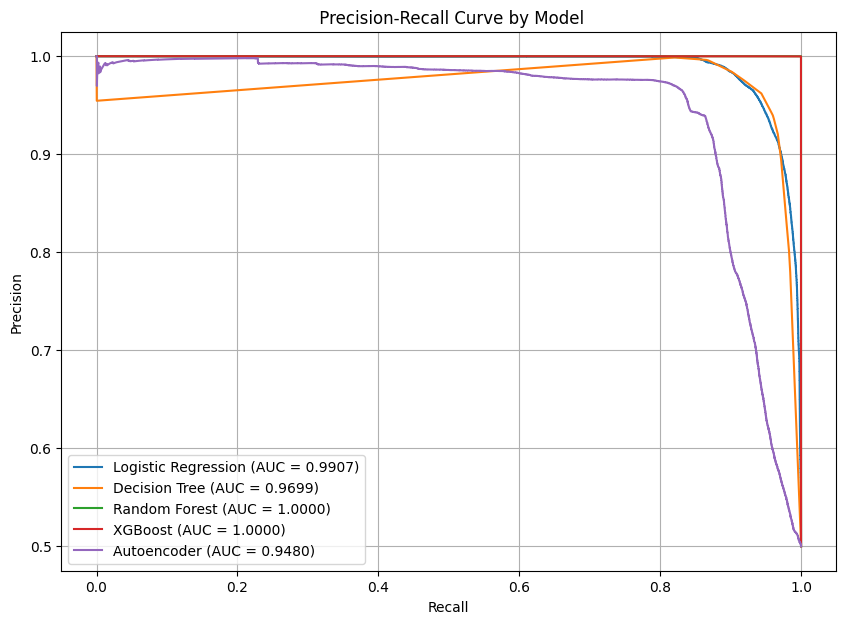

In [41]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

#  모델별 예측 확률 리스트 (클래스 1에 대한 확률)
model_probs = {
    "Logistic Regression": y_pred_proba_lr[:, 1],
    "Decision Tree": y_pred_proba_dt[:, 1],
    "Random Forest": y_pred_proba_rf[:, 1],
    "XGBoost": y_pred_proba_xgb,  # XGB는 predict_proba 없이 predict면 확률로 나옴
    "Autoencoder": y_pred_ae_prob  # Reconstruction error 기반
}

plt.figure(figsize=(10, 7))

for model_name, y_score in model_probs.items():
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.4f})")

plt.title(" Precision-Recall Curve by Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

🔍 해석

Random Forest / XGBoost
- 두 모델 모두 AUC-ROC와 PR AUC가 1.0000으로 완벽한 이상탐지 성능을 보여줌
- SMOTE를 활용한 균형 잡힌 학습 덕분에 recall도 높음
- 현실에서는 과적합 가능성 고려해 교차검증 필요

Logistic Regression
- 단순하지만 안정적인 결과, precision과 recall 모두 우수 (0.97 / 0.91)
- 실제 적용에서 해석 가능성도 높아 현업 사용 가능성 좋음

Decision Tree
- 비슷한 수준이지만 약간의 과적합 경향. 성능은 좋지만 랜덤포레스트보다 열세

Autoencoder
- 딥러닝 기반의 비지도 학습 방식으로 Precision은 매우 높지만 Recall이 낮아 탐지 누락 위험 존재
- Reconstruction Error 기반의 임계값 조정으로 성능 향상 여지 있음

Isolation Forest
- 비지도 이상탐지 전용 모델이지만, 이 데이터셋에서는 성능 부적절
- Precision은 높지만 Recall이 낮아 의미 있는 탐지 불가

➡️ 정밀하고 놓치지 않는 사기 탐지가 필요하다면 Random Forest, XGBoost가 최우수

➡️ 모델 해석력과 빠른 추론 시간이 중요하다면 Logistic Regression도 좋은 대안

➡️ Autoencoder는 비지도 학습 상황에서의 출발점으로 사용 가능하지만 성능 조정 필요